## Assignment 2 - M-estimator of Location

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

np.random.seed(123)

### Task 2: Designing Your Own M-Estimator of the Mean

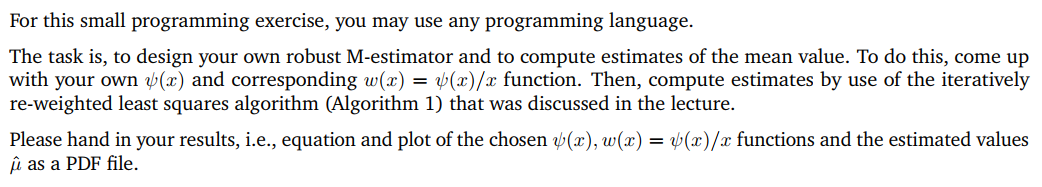

#### Functions for the M-Estimation

In [169]:
def weight_function(x: float) -> float:
    if x >= 0 and x <= 3:
        return 1 - x/3
    elif x < 0 and x >= -3:
        return 1 + x/3
    else:
        return 0

def weight_function_vectorized(x: np.ndarray) -> np.ndarray:
    return np.vectorize(weight_function)(x)

def phi_function(x: float) -> float:
    return weight_function(x)*x

def rho_scale_vectorized(x: np.ndarray) -> np.ndarray:
    return x * np.vectorize(phi_function)(x)

In [170]:
def m_estimator_loc(samples, weight_function, initial_mean_estimate = None, std_estimate=None, epsilon=0.001):
    if initial_mean_estimate is None:
        initial_mean_estimate = np.median(samples)
    if std_estimate is None:
        std_estimate = stats.median_abs_deviation(samples, scale='normal')
    
    mu_i = initial_mean_estimate
    sigma = std_estimate
    iterations_count = 0
    diff = 1

    while diff > epsilon:
        iterations_count += 1
        weights = weight_function((samples - mu_i) / sigma)
        mu_i_1 = np.sum(weights * samples) / np.sum(weights)
        diff = abs(mu_i - mu_i_1)/sigma
        mu_i = mu_i_1
    
    return mu_i, iterations_count, diff

In [171]:
def m_estimator_scale(samples, weight_function, b, mean_estimate = None, initial_std_estimate = None, epsilon=0.001):
    if mean_estimate is None:
        mean_estimate = np.median(samples)
    if initial_std_estimate is None:
        initial_std_estimate = stats.median_abs_deviation(samples, scale='normal')
    
    mu = mean_estimate
    sigma_i = initial_std_estimate
    iterations_count = 0
    diff = 1
    N = len(samples)

    while diff > epsilon:
        iterations_count += 1
        weights = weight_function((samples - mu) / sigma_i)
        sigma_i_1 = np.sqrt(1/(N*b) * np.sum(weights * (samples - mu)**2))
        diff = abs(sigma_i_1/sigma_i - 1)
        sigma_i = sigma_i_1
        
    return sigma_i, iterations_count, diff

#### Plots of Weight and Score Function

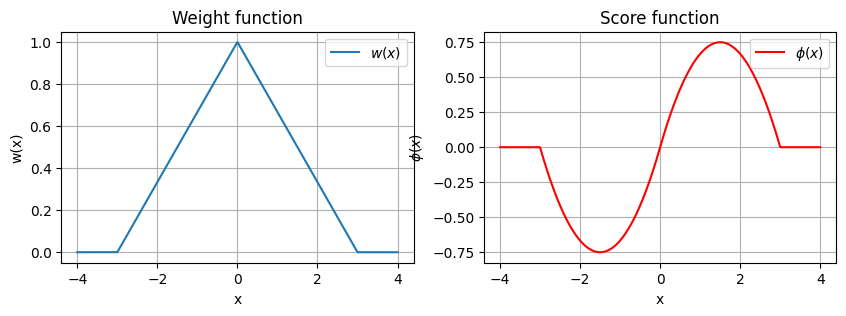

In [172]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

x_array = np.linspace(-4, 4, 1000)
axes[0].plot(x_array, [weight_function(x) for x in x_array], label='$w(x)$')
axes[1].plot(x_array, [phi_function(x) for x in x_array], label='$\phi(x)$', color='red')

axes[0].set_title('Weight function')
axes[0].set_xlabel('x')
axes[0].set_ylabel('w(x)')
axes[0].legend()
axes[0].grid()

axes[1].set_title('Score function')
axes[1].set_xlabel('x')
axes[1].set_ylabel('$\phi(x)$')
axes[1].legend()
axes[1].grid()

plt.show()

#### Samples

In [173]:
epsilon = 0.001

y_array = np.array([1.03, 0.72, -0.30, 0.29, -5.78])

#### Estimate of Parameter "b"

In [174]:
samples_normal_dist = np.random.normal(0, 1, 1000)

# monte carlo integration for the expected value of the scale function
b = rho_scale_vectorized(samples_normal_dist).mean()

print(f'Expected value of the scale function: b = {b}')

Expected value of the scale function: b = 0.4735718420871968


#### Initial Values of $\mu$ and $\sigma$

- $\hat{\mu_0} =$ median
- $\hat{\sigma_0} =$ Median absolute deviation

In [175]:
mu_0 = np.median(y_array)
sigma_0 = stats.median_abs_deviation(y_array, scale='normal')

print(f'Median: {mu_0}')
print(f'Median absolute deviation: {sigma_0}')

Median: 0.29
Median absolute deviation: 0.8747353089183051


#### M-Estimation of the Scale $\hat{\sigma}$

In [176]:
scale, iterations_count, diff = m_estimator_scale(samples=y_array,
                                                  weight_function=weight_function_vectorized,
                                                  b=b, mean_estimate=mu_0,initial_std_estimate=sigma_0,
                                                  epsilon=epsilon)

print(f'Estimated scale: {scale}')
print(f'Number of iterations: {iterations_count}')
print(f'Error: {diff}')

Estimated scale: 0.518824633948727
Number of iterations: 7
Error: 0.0003571711154674029


#### M-Estimation of the Location $\hat{\mu}$ based on $\hat{\sigma}$

In [177]:
loc, iterations_count, diff = m_estimator_loc(samples=y_array,
                                              weight_function=weight_function_vectorized,
                                              std_estimate=scale, initial_mean_estimate=mu_0,
                                              epsilon=epsilon)

print(f'Estimated location parameter: {loc}')
print(f'Number of iterations: {iterations_count}')
print(f'Error: {diff}')

Estimated location parameter: 0.4812821466821967
Number of iterations: 7
Error: 0.000838151693607797


#### M-Estimation of the Location $\hat{\mu}$ based on $\hat{\sigma_0}$

In [178]:
loc, iterations_count, diff = m_estimator_loc(samples=y_array,
                                              weight_function=weight_function_vectorized,
                                              std_estimate=sigma_0, initial_mean_estimate=mu_0,
                                              epsilon=epsilon)

print(f'Estimated location parameter: {loc}')
print(f'Number of iterations: {iterations_count}')
print(f'Error: {diff}')

Estimated location parameter: 0.4530057009926824
Number of iterations: 5
Error: 0.00024513808562892734


### Task 3: Bias of an M-Estimator of the Mean

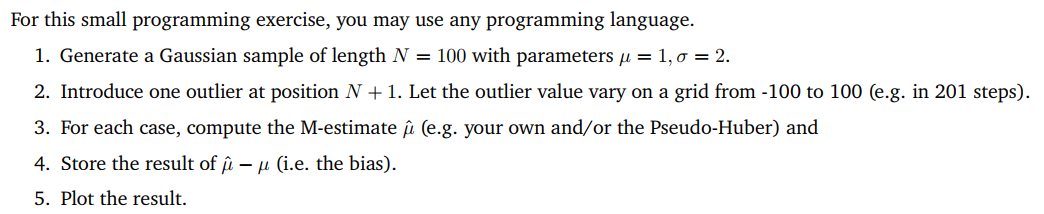

#### Original Distribution of the Samples

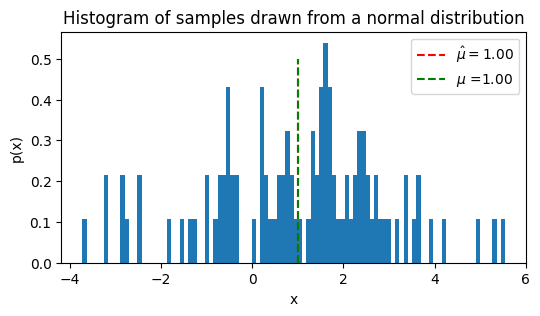

In [179]:
loc = 1
scale = 2
N = 100

samples = np.random.normal(loc, scale, N)
samples_mean = np.mean(samples)

plt.figure(figsize=(6, 3))
plt.hist(samples, bins=100, density=True)
plt.vlines(loc, 0, 0.5, color='red', linestyles="dashed", label='$\hat{\mu} =$' + '{:.2f}'.format(loc))
plt.vlines(loc, 0, 0.5, color='green', linestyles="dashed", label='$\mu$ =' + '{:.2f}'.format(samples_mean))
plt.title('Histogram of samples drawn from a normal distribution')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()
plt.show()

In [180]:
print("Samples shape: ", samples.shape)
print(f"Sample Mean: {np.mean(samples):.3f}")

Samples shape:  (100,)
Sample Mean: 1.002


In [181]:
samples_with_outliers = [samples.tolist() + [outlier] for outlier in range(-100, 101)]
samples_with_outliers = pd.DataFrame(samples_with_outliers, columns=[f"sample_{i}" for i in range(N)] + ["outlier"])

samples_with_outliers.head()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99,outlier
0,-0.497655,2.135189,2.436301,-0.998761,1.949797,-2.737,0.594682,-1.268496,-0.615399,-1.552155,...,5.54621,0.807218,-2.884264,0.326817,-2.45178,2.222476,3.618702,2.391759,1.640616,-100
1,-0.497655,2.135189,2.436301,-0.998761,1.949797,-2.737,0.594682,-1.268496,-0.615399,-1.552155,...,5.54621,0.807218,-2.884264,0.326817,-2.45178,2.222476,3.618702,2.391759,1.640616,-99
2,-0.497655,2.135189,2.436301,-0.998761,1.949797,-2.737,0.594682,-1.268496,-0.615399,-1.552155,...,5.54621,0.807218,-2.884264,0.326817,-2.45178,2.222476,3.618702,2.391759,1.640616,-98
3,-0.497655,2.135189,2.436301,-0.998761,1.949797,-2.737,0.594682,-1.268496,-0.615399,-1.552155,...,5.54621,0.807218,-2.884264,0.326817,-2.45178,2.222476,3.618702,2.391759,1.640616,-97
4,-0.497655,2.135189,2.436301,-0.998761,1.949797,-2.737,0.594682,-1.268496,-0.615399,-1.552155,...,5.54621,0.807218,-2.884264,0.326817,-2.45178,2.222476,3.618702,2.391759,1.640616,-96


In [209]:
locations_m_estimates = samples_with_outliers.apply(lambda x: m_estimator_loc(x, weight_function_vectorized, epsilon=1e-6)[0], axis=1)
sample_means = samples_with_outliers.mean(axis=1)

print("M-Locations: ")
print(locations_m_estimates)
print("\nSample Means: ")
print(sample_means)

M-Locations: 
0      1.184212
1      1.184212
2      1.184212
3      1.184212
4      1.184212
         ...   
196    1.175866
197    1.175866
198    1.175866
199    1.175866
200    1.175866
Length: 201, dtype: float64

Sample Means: 
0      0.001901
1      0.011802
2      0.021703
3      0.031604
4      0.041505
         ...   
196    1.942495
197    1.952396
198    1.962297
199    1.972198
200    1.982099
Length: 201, dtype: float64


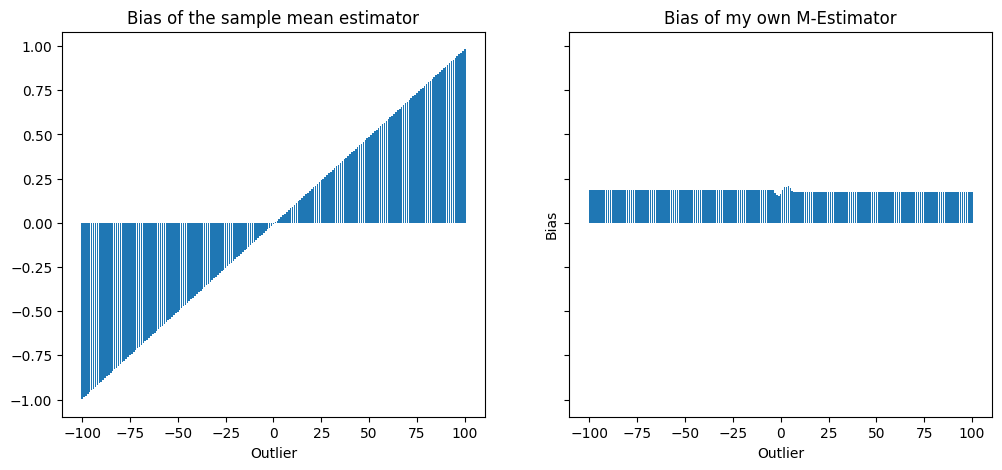

In [210]:
m_estimator_bias_s = locations_m_estimates - loc
sample_mean_bias_s = sample_means - loc

outliers_s = samples_with_outliers["outlier"]

_, axes = plt.subplots(figsize=(12, 5), sharey=True, nrows=1, ncols=2)

axes[0].bar(samples_with_outliers["outlier"], sample_mean_bias_s, label='Sample Mean')
axes[0].set_title('Bias of the sample mean estimator')
axes[0].set_xlabel('Outlier')

axes[1].bar(samples_with_outliers["outlier"], m_estimator_bias_s, label='M-Estimator')
axes[1].set_title('Bias of my own M-Estimator')
axes[1].set_xlabel('Outlier')

plt.ylabel('Bias')
plt.show()

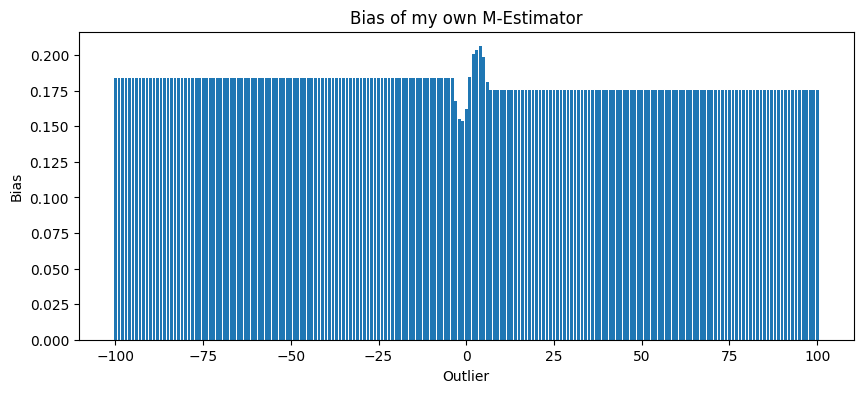

In [211]:
plt.figure(figsize=(10, 4))
plt.bar(samples_with_outliers["outlier"], m_estimator_bias_s, label='M-Estimator')
plt.title('Bias of my own M-Estimator')
plt.xlabel('Outlier')
plt.ylabel('Bias')
plt.show()

In [212]:
abs_bias_s = m_estimator_bias_s.abs()

print("Maximum bias: ", abs_bias_s.max())
print("Outlier for maximum bias: ", outliers_s.iloc[abs_bias_s.idxmax()])

print("Minimum bias: ", abs_bias_s.min())
print("Outlier for minimum bias: ", outliers_s.iloc[abs_bias_s.idxmin()])

print("Bias for outlier 100: ", abs_bias_s.iloc[outliers_s[outliers_s == 100].index[0]])
print("Bias for outlier -100: ", abs_bias_s.iloc[outliers_s[outliers_s == -100].index[0]])


Maximum bias:  0.2062270601354379
Outlier for maximum bias:  4
Minimum bias:  0.15374922099472998
Outlier for minimum bias:  -1
Bias for outlier 100:  0.1758663498242008
Bias for outlier -100:  0.18421223719312652


In [213]:
mloc_without_outliers, m_scale, _ = m_estimator_loc(samples, weight_function_vectorized)
bias = mloc_without_outliers - loc
print("Bias without outliers: ", bias)

print("M-Location without outliers: ", mloc_without_outliers)
z_score_100 = (100 - loc) / scale
print("Weight of outlier 100: ", weight_function(z_score_100))

z_score_neg_100 = (-100 - loc) / scale
print("Weight of outlier -100: ", weight_function(z_score_neg_100))

Bias without outliers:  0.1835361191259539
M-Location without outliers:  1.183536119125954
Weight of outlier 100:  0
Weight of outlier -100:  0
